In [7]:
# use this notebook to compare the zero-shot and fine-tuned performance of TimerXL model
import os
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from iotdb.ainode.core.model.timerxl.modeling_timer import TimerForPrediction
from iotdb.ainode.core.training.tools.max_heap import MaxHeap

# not a bad config
lookback_length = 1024
prediction_length = 96

model_path = "/data/yongzao/timecho-ainode/iotdb-core/ainode/ainode/core/data/ainode/models/weights"
raw_model_id = "timer_xl"
fine_tune_model_id = "timerxlBAOFULL"

dataset_path = "/data/yongzao/dataset/demo-set"
dataset_file_name = "baoshan-01-temperature.csv"
value_path = "root.baoshan.temperature.value"

In [8]:
# load model and dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# refactor the following path to your own environment

raw_model = TimerForPrediction.from_pretrained(os.path.join(model_path, raw_model_id))
raw_model = raw_model.to(device)
fine_tune_model = TimerForPrediction.from_pretrained(
    os.path.join(model_path, fine_tune_model_id)
)
fine_tune_model = fine_tune_model.to(device)
print(next(raw_model.parameters()).device, next(fine_tune_model.parameters()).device)

cuda:0 cuda:0


In [9]:
# refactor the following path to your own environment

df = pd.read_csv(os.path.join(dataset_path, dataset_file_name))
value = torch.tensor(df[value_path].values, dtype=torch.float32)
value = value.to(device)
print(value.device)

cuda:0


In [10]:
# compare zero-shot and fine-tuned loss
heap = MaxHeap()
start_index = 18000 - lookback_length
# end_index = start_index + 10
end_index = 20000 - lookback_length - prediction_length

mse_improve_list = []
raw_total_mse_loss = torch.tensor(0.0).to(device)
raw_total_mae_loss = torch.tensor(0.0).to(device)
fine_tune_total_mse_loss = torch.tensor(0.0).to(device)
fine_tune_total_mae_loss = torch.tensor(0.0).to(device)
total_count = torch.tensor(0.0).to(device)
for i in range(start_index, end_index):
    # prepare input & ground truth
    seqs = value[i : (i + lookback_length)].unsqueeze(0)
    truth = value[i + lookback_length : (i + lookback_length + prediction_length)]

    # generate forecast
    output_raw = raw_model.generate(seqs, max_new_tokens=prediction_length, revin=True)
    output_raw = output_raw[0]
    output_fine_tune = fine_tune_model.generate(
        seqs, max_new_tokens=prediction_length, revin=True
    )
    output_fine_tune = output_fine_tune[0]

    # sum the loss
    cur_raw_mse_loss = (
        F.mse_loss(output_raw, truth, reduction="none").mean(dim=-1).sum()
    )
    cur_raw_mae_loss = F.l1_loss(output_raw, truth, reduction="none").mean(dim=-1).sum()
    cur_fine_tune_mse_loss = (
        F.mse_loss(output_fine_tune, truth, reduction="none").mean(dim=-1).sum()
    )
    cur_fine_tune_mae_loss = (
        F.l1_loss(output_fine_tune, truth, reduction="none").mean(dim=-1).sum()
    )

    mse_improve = (cur_raw_mse_loss - cur_fine_tune_mse_loss) / cur_raw_mse_loss * 100
    mse_improve_list.append(mse_improve.item())
    heap.push(i, mse_improve.item())

    raw_total_mse_loss += cur_raw_mse_loss
    raw_total_mae_loss += cur_raw_mae_loss
    fine_tune_total_mse_loss += cur_fine_tune_mse_loss
    fine_tune_total_mae_loss += cur_fine_tune_mae_loss
    total_count += 1

    if i % 100 == 0:
        print(f"Processed {i - start_index + 1} samples...")

# compare the loss
raw_total_mse_loss = raw_total_mse_loss / total_count
raw_total_mae_loss = raw_total_mae_loss / total_count
fine_tune_total_mse_loss = fine_tune_total_mse_loss / total_count
fine_tune_total_mae_loss = fine_tune_total_mae_loss / total_count
print(
    f"TimerXL zero-shot MSE Loss: {raw_total_mse_loss:.4f}, MAE Loss: {raw_total_mae_loss:.4f}"
)
print(
    f"TimerXL fine-tuned MSE Loss: {fine_tune_total_mse_loss:.4f}, MAE Loss: {fine_tune_total_mae_loss:.4f}"
)
print(
    f"Improvement of MSE Loss: {((raw_total_mse_loss - fine_tune_total_mse_loss) / raw_total_mse_loss * 100):.2f}%"
)
print(
    f"Improvement of MAE Loss: {((raw_total_mae_loss - fine_tune_total_mae_loss) / raw_total_mae_loss * 100):.2f}%"
)

# record the best 20 points
for i in range(20):
    index, mse_improve = heap.pop()
    print(f"Index: {index}, MSE Improvement: {mse_improve:.2f}%")

Processed 25 samples...
Processed 125 samples...
Processed 225 samples...
Processed 325 samples...
Processed 425 samples...
Processed 525 samples...
Processed 625 samples...
Processed 725 samples...
Processed 825 samples...
Processed 925 samples...
Processed 1025 samples...
Processed 1125 samples...
Processed 1225 samples...
Processed 1325 samples...
Processed 1425 samples...
Processed 1525 samples...
Processed 1625 samples...
Processed 1725 samples...
Processed 1825 samples...
TimerXL zero-shot MSE Loss: 1.4112, MAE Loss: 0.7595
TimerXL fine-tuned MSE Loss: 1.3454, MAE Loss: 0.7597
Improvement of MSE Loss: 4.66%
Improvement of MAE Loss: -0.03%
Index: 18693, MSE Improvement: 72.87%
Index: 18694, MSE Improvement: 72.55%
Index: 18556, MSE Improvement: 71.79%
Index: 18695, MSE Improvement: 70.84%
Index: 18709, MSE Improvement: 65.01%
Index: 18692, MSE Improvement: 64.07%
Index: 18703, MSE Improvement: 59.46%
Index: 18711, MSE Improvement: 58.44%
Index: 18715, MSE Improvement: 57.71%
Index

TimerXL zero-shot MSE Loss: 0.0134, MAE Loss: 0.1081
TimerXL fine-tuned MSE Loss: 0.0038, MAE Loss: 0.0519
Improvement of MSE Loss: 71.79%
Improvement of MAE Loss: 51.98%


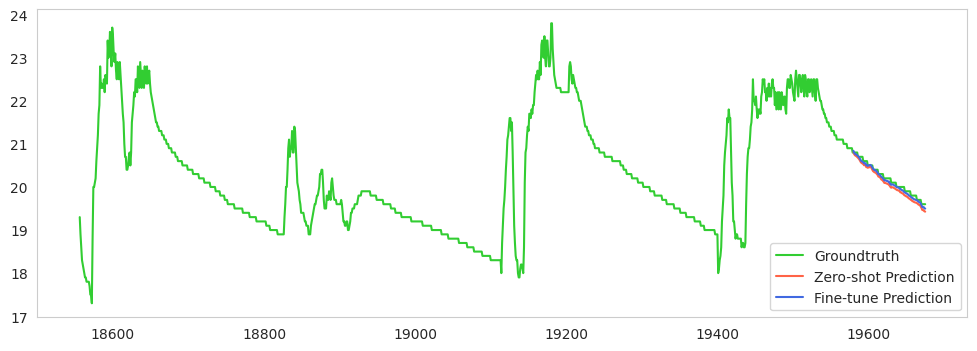

In [22]:
# Sample visualization
start = 18556

# prepare input & ground truth
seqs = value[start : (start + lookback_length)].unsqueeze(0)
truth = value[start + lookback_length : (start + lookback_length + prediction_length)]

# generate forecast
output_raw = raw_model.generate(seqs, max_new_tokens=prediction_length, revin=True)
output_raw = output_raw[0]
output_fine_tune = fine_tune_model.generate(
    seqs, max_new_tokens=prediction_length, revin=True
)
output_fine_tune = output_fine_tune[0]

raw_mse_loss = F.mse_loss(output_raw, truth, reduction="none").mean(dim=-1).sum()
raw_mae_loss = F.l1_loss(output_raw, truth, reduction="none").mean(dim=-1).sum()
fine_tune_mse_loss = (
    F.mse_loss(output_fine_tune, truth, reduction="none").mean(dim=-1).sum()
)
fine_tune_mae_loss = (
    F.l1_loss(output_fine_tune, truth, reduction="none").mean(dim=-1).sum()
)
print(f"TimerXL zero-shot MSE Loss: {raw_mse_loss:.4f}, MAE Loss: {raw_mae_loss:.4f}")
print(
    f"TimerXL fine-tuned MSE Loss: {fine_tune_mse_loss:.4f}, MAE Loss: {fine_tune_mae_loss:.4f}"
)
print(
    f"Improvement of MSE Loss: {((raw_mse_loss - fine_tune_mse_loss) / raw_mse_loss * 100):.2f}%"
)
print(
    f"Improvement of MAE Loss: {((raw_mae_loss - fine_tune_mae_loss) / raw_mae_loss * 100):.2f}%"
)

# visualize
plt.figure(figsize=(12, 4))
plt.plot(
    df[value_path][start : (start + lookback_length + prediction_length)],
    color="limegreen",
    label="Groundtruth",
)
plt.plot(
    range(start + lookback_length, start + lookback_length + prediction_length),
    output_raw.cpu(),
    color="tomato",
    label="Zero-shot Prediction",
)
plt.plot(
    range(start + lookback_length, start + lookback_length + prediction_length),
    output_fine_tune.cpu(),
    color="royalblue",
    label="Fine-tune Prediction",
)
plt.legend()
plt.grid()
plt.show()

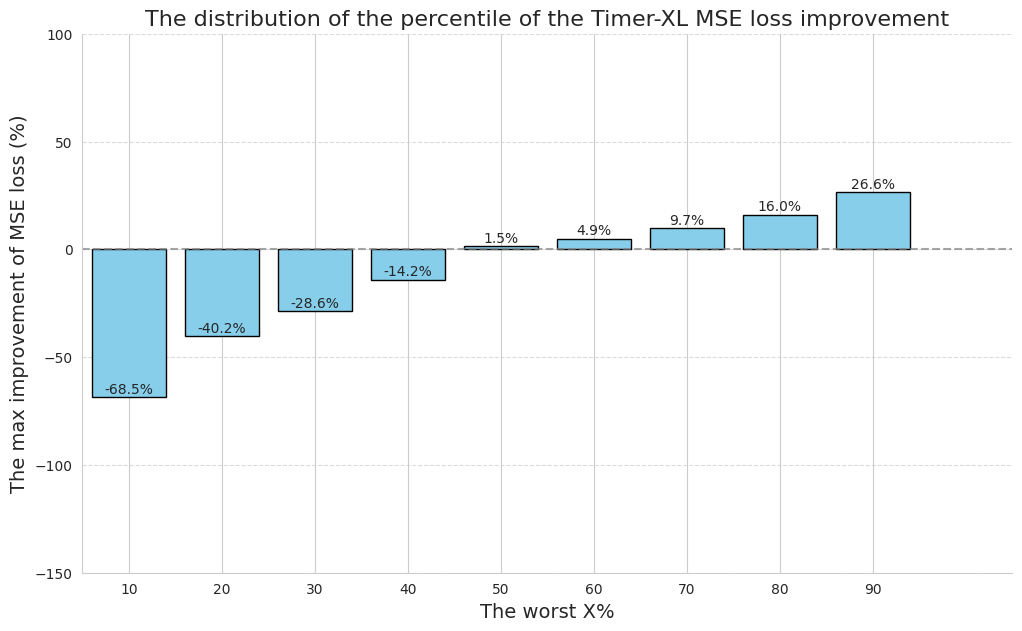

In [20]:
import numpy as np
import seaborn as sns

improvement_values = np.array(mse_improve_list)

quantiles = np.arange(90, -1, -10)
percentile_labels = 100 - quantiles
percentile_values = np.percentile(improvement_values, quantiles)

sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

bars = plt.bar(
    quantiles, percentile_values, width=8, color="skyblue", edgecolor="black"
)
for bar, q, val in zip(bars, quantiles, percentile_values):
    if val < -150:
        continue
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.5,
        f"{val:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.axhline(y=0, color="gray", linestyle="--", alpha=0.7)

plt.title(
    "The distribution of the percentile of the Timer-XL MSE loss improvement",
    fontsize=16,
)
plt.xlabel("The worst X%", fontsize=14)
plt.ylabel("The max improvement of MSE loss (%)", fontsize=14)
plt.ylim(-150, 100)
plt.grid(True, linestyle="--", alpha=0.7, axis="y")
plt.xticks(quantiles)
plt.xlim(5, 105)


sns.despine()
plt.show()